# EDA

# 1st step: let's see how many unique features do we have, their field types and also dataset size

In [159]:
import json
import os
from pathlib import Path

dataset = Path('/Users/layvvs/Desktop/HSE/Studying/year-project/downloaded_tracks')

meta_data = dataset/'metadata'
audio_data = dataset/'audio'

## Dataset size

In [160]:
meta_data_content = os.listdir(meta_data)
audio_data_content = os.listdir(audio_data)

meta_data_size = len(meta_data_content)
audio_data_size = len(audio_data_content)

print('Meta data size:', meta_data_size)
print('Audio data size:', audio_data_size)

Meta data size: 2001
Audio data size: 2001


## Fields and their types

In [161]:
from collections import Counter
import pandas as pd

fields_count = Counter()


def parse_field(field, content):
    if not isinstance(content, dict):
        return [(field, type(content).__name__)]
    result = []
    for subfield, subcontent in content.items():
        result.extend(parse_field(subfield, subcontent))
    return result


for meta_data_file in meta_data_content:
    with open(meta_data/meta_data_file) as f:
        data: dict = json.load(f)
        fields = []
        for field, content in data.items():
            fields.extend(parse_field(field, content))
        fields_count.update(fields)


dataset_info = pd.DataFrame(
    [
        (field[0], field[1], field_count)
        for field, field_count in fields_count.items()
    ],
    columns=['field', 'type', 'count']
)
dataset_info

field   type  count
0                     id    str   2001
1                   name    str   2001
2               duration    int   2001
3              artist_id    str   2001
4            artist_name    str   2001
5               album_id    str   2001
6             album_name    str   2001
7            releasedate    str   2001
8               waveform    str   2000
9      vocalinstrumental    str   2001
10                  lang    str   2001
11                gender    str   2001
12      acousticelectric    str   2001
13                 speed    str   2001
14                genres   list   2001
15           instruments   list   2001
16               vartags   list   2001
17  rate_downloads_total    int   2001
18   rate_listened_total    int   2001
19            playlisted    int   2001
20             favorited    int   2001
21                 likes    int   2001
22              dislikes    int   2001
23               avgnote    int   1423
24               avgnote  float    578

### Intermediate conclusions
At this point we've `23` unique features (we'll take `avgnote` as `float`).

Now we've to decide how add audio, waveform and list to dataframe.

I think i'll create another file for the peaks values and add the file path to the table for the audio as well.

For the categorical features (list, str) we can use type casting (many string types in data originally are int or float), encodings and text embeddings.

# 2nd step: data preprocessing. Type casting, encoding and embeddings 

## Let's look at the unique values of categorical data

Field artist_id, unique values 669
Field album_id, unique values 1065
Field vocalinstrumental, unique values 3
Field lang, unique values 9
Field gender, unique values 4
Field acousticelectric, unique values 3
Field speed, unique values 6
Field genres, unique values 140
Field instruments, unique values 61
Field vartags, unique values 463


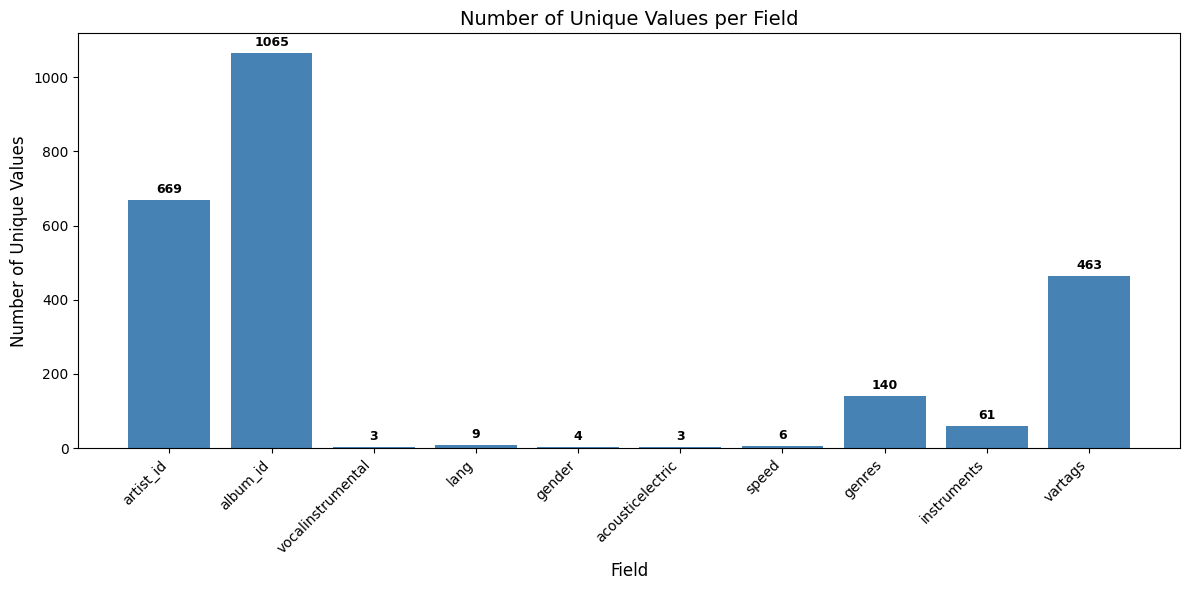

In [162]:
from collections import defaultdict
import matplotlib.pyplot as plt

skip_fileds = ['id', 'artist_name', 'album_name', 'releasedate', 'waveform', 'name']

unique_values = defaultdict(set)

def parse_field(field, content):
    if isinstance(content, float) or isinstance(content, int) or field in skip_fileds:
        return
    if isinstance(content, list):
        unique_values[field].update(content)
        return
    if isinstance(content, str):
        unique_values[field].update([content])
        return
    for subfield, subcontent in content.items():
        parse_field(subfield, subcontent)

for meta_data_file in meta_data_content:
    with open(meta_data/meta_data_file) as f:
        data: dict = json.load(f)
        for field, content in data.items():
            parse_field(field, content)

field_counts = {field: len(values) for field, values in unique_values.items()}

for field, content in field_counts.items():
    print(f'Field {field}, unique values {content}')

fields, counts = zip(*field_counts.items())

plt.figure(figsize=(12, 6))
bars = plt.bar(fields, counts, color='steelblue')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(counts) * 0.01,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )

plt.title('Number of Unique Values per Field', fontsize=14)
plt.xlabel('Field', fontsize=12)
plt.ylabel('Number of Unique Values', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Intermediate conclusions
* We can see that we've `669` *unique artists*, `1065` *unique albums* and `2001` *songs* in current dataset.

* We can use different techniques of encoding for fields `vocalinstrumental`, `lang`, `gender`, `acousticelectric`, `speed` because of small amount of unique values.

* We can split field `releasedate` on year/mont/day columns.

* I think we should use an embedding model for fields `genres`, `instuments`, `vartags`.

We can also drop fields like song/artist/album name, id-fields for model training, but rn i'm not sure about this. We'll see

In [163]:
for field, values in unique_values.items():
    print(f'Field {field}, unique values {values}')

Field artist_id, unique values {'498715', '509386', '8303', '457603', '357396', '358087', '496541', '421686', '378695', '348433', '366801', '428294', '367346', '454156', '340291', '345816', '367151', '338779', '354307', '480445', '462184', '339724', '344760', '522305', '344688', '1333', '5374', '467550', '487051', '353387', '467034', '340121', '337983', '426658', '359156', '490381', '375106', '2210', '511213', '542401', '437999', '353120', '351372', '540036', '533079', '6615', '493564', '551902', '442010', '361689', '499734', '2020', '490453', '495807', '475967', '2208', '338582', '506990', '386200', '474132', '376782', '337294', '371777', '504167', '370143', '357466', '341681', '491380', '349911', '473685', '492967', '362044', '1301', '506072', '517272', '503091', '436631', '457964', '421017', '339779', '340555', '370748', '343172', '519486', '5611', '456653', '347881', '498188', '163', '421034', '345952', '7805', '340553', '358789', '366820', '342507', '378219', '352814', '430396', '

## Data encoding

Let's apply *one-hot encoding* for `lang`, `gender`, `acousticelectric` and *label encoding* for `speed`

In [164]:
# Нужно поработать с полученной табличкой - поулучшать ее, опираясь на информацию выше. можно попробовать уже добавить эмбеддингов на некоторые фичи и как-то покластеризовать данные (T-SNE) 
# Также можно сравнить песни по waveformам
# Вообще нужно глянуть как EDA чуваки делают, есть же наверное куча инструментов для бейзлайна

all_data = []

for meta_data_file in meta_data_content:
    with open(meta_data/meta_data_file) as f:
        data = json.load(f)
        if isinstance(data, dict):
            all_data.append(data)


df = pd.json_normalize(all_data)

df.reset_index(drop=True, inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')

df['releasedate'] = df['releasedate'].apply(pd.to_datetime)

df['releasedate_year'] = df['releasedate'].dt.year
df['releasedate_month'] = df['releasedate'].dt.month
df['releasedate_day'] = df['releasedate'].dt.day

df = df.drop('releasedate', axis=1)

df['track_speed_low'] = df['musicinfo.speed'].isin(['low', 'verylow']).astype(int)
df['track_speed_medium'] = (df['musicinfo.speed'] == 'medium').astype(int)
df['track_speed_high'] = df['musicinfo.speed'].isin(['high', 'veryhigh']).astype(int)
df['track_speed_not_specified'] = (df['musicinfo.speed'] == '').astype(int)

df = df.drop('musicinfo.speed', axis=1)

df['artist_gender_male'] = (df['musicinfo.gender'] == 'male').astype(int)
df['artist_gender_female'] = (df['musicinfo.gender'] == 'female').astype(int)
df['artist_gender_neutral'] = (df['musicinfo.gender'] == 'neutral').astype(int)
df['artist_gender_not_specified'] = (df['musicinfo.gender'] == '').astype(int)

df = df.drop('musicinfo.gender', axis=1)

df['acoustic'] = (df['musicinfo.acousticelectric'] == 'acoustic').astype(int)
df['electric'] = (df['musicinfo.acousticelectric'] == 'electric').astype(int)
df['acousticelectric_not_specified'] = (df['musicinfo.acousticelectric'] == '').astype(int)

df = df.drop('musicinfo.acousticelectric', axis=1)

df['vocal'] = (df['musicinfo.vocalinstrumental'] == 'vocal').astype(int)
df['instrumental'] = (df['musicinfo.vocalinstrumental'] == 'instrumental').astype(int)
df['vocalinstrumental'] = (df['musicinfo.vocalinstrumental'] == '').astype(int)

df = df.drop('musicinfo.vocalinstrumental', axis=1)

df.head()


/var/folders/3t/gyxj9s512yx6klv5c576ykyc0000gn/T/ipykernel_70688/448662633.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


id               name  duration  artist_id          artist_name  \
0  1093617   Love Too Serious       264     378695           Lilly Wolf   
1  1466886     Girls Like You       198     498715       The Spin Wires   
2   159927  Put That Boy Away       234     339246             Dan Bryk   
3  1319749         Epic Music       110     487189  Aliaksei Yukhnevich   
4   248375              Shine       170     344760          Circa Vitae   

   album_id         album_name  \
0  130349.0          Play Loud   
1  170073.0  The Spin Wires EP   
2   23027.0     Discount Store   
3  263838.0         Epic Music   
4   35849.0     CIRCA VITAE ep   

                                            waveform musicinfo.lang  \
0  {"peaks":[95,43,79,65,14,7,28,86,44,65,57,20,2...             en   
1  {"peaks":[71,71,69,69,88,84,62,66,84,70,48,84,...             en   
2  {"peaks":[16,90,38,36,89,27,9,20,29,98,83,31,9...                  
3  {"peaks":[0,0,1,2,3,4,6,8,11,12,12,14,16,15,18...                  
4  {"peaks":[7,6,6,6,5,4,4,4,5,6,5,5,8,7,5,8,7,4,...             en   

                musicinfo.tags.genres  ... artist_gender_male  \
0              [pop, dance, synthpop]  ...                  0   
1  [rock, alternativerock, indierock]  ...                  1   
2                               [pop]  ...                  1   
3              [filmscore, symphonic]  ...                  0   
4            [rock, indierock, indie]  ...                  1   

  artist_gender_female  artist_gender_neutral  artist_gender_not_specified  \
0                    1                      0                            0   
1                    0                      0                            0   
2                    0                      0                            0   
3                    0                      0                            1   
4                    0                      0                            0   

   acoustic  electric  acousticelectric_not_specified  vocal  instrumental  \
0         0         1                               0      1             0   
1         0         0                               1      1             0   
2         0         0                               1      1             0   
3         0         0                               1      0             1   
4         0         0                               1      1             0   

   vocalinstrumental  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 36 columns]

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              2001 non-null   int64  
 1   name                            2001 non-null   object 
 2   duration                        2001 non-null   int64  
 3   artist_id                       2001 non-null   int64  
 4   artist_name                     2001 non-null   object 
 5   album_id                        1997 non-null   float64
 6   album_name                      2001 non-null   object 
 7   waveform                        2000 non-null   object 
 8   musicinfo.lang                  2001 non-null   object 
 9   musicinfo.tags.genres           2001 non-null   object 
 10  musicinfo.tags.instruments      2001 non-null   object 
 11  musicinfo.tags.vartags          2001 non-null   object 
 12  stats.rate_downloads_total      20

Let's find top-10 most common values for genre, vartags and instruments.

In [166]:
vartags_counter =  Counter()
genres_counter = Counter()
instruments_counter = Counter()

for row in df['musicinfo.tags.vartags']:
    vartags_counter.update(row)

for row in df['musicinfo.tags.genres']:
    genres_counter.update(row)

for row in df['musicinfo.tags.instruments']:
    instruments_counter.update(row)

vartags_counter_mc = vartags_counter.most_common(10) 
genres_counter_mc = genres_counter.most_common(10)
instruments_counter = instruments_counter.most_common(10)

print(vartags_counter_mc)
print(genres_counter_mc)
print(instruments_counter)

[('voice', 1147), ('vocal', 1051), ('acoustic', 573), ('neutral', 238), ('energetic', 229), ('peaceful', 229), ('happy', 217), ('love', 149), ('upbeat', 101), ('soft', 95)]
[('pop', 615), ('rock', 382), ('electronic', 356), ('jazz', 257), ('indie', 151), ('folk', 144), ('chillout', 102), ('ambient', 98), ('dance', 97), ('singersongwriter', 92)]
[('strings', 309), ('piano', 293), ('synthesizer', 276), ('guitar', 198), ('drums', 188), ('electricguitar', 185), ('electroamplified', 99), ('bass', 73), ('acousticguitar', 53), ('saxophone', 45)]


Now we know that the most popular vartag is 'voice', the most popular genre is 'pop' and the most popular instrument is 'strings'

Let's use this top-10 for OHE instead of adding 650+ columns.

There was a suggestion to use TF-IDF (or bm25) for columns with array datatype to chose the most valuable termins but i think it won't work because arrays only have unique words instead of sentences so OHE fits better i think

Let's also drop waveform feature because we don't know how it was produced and we will use it later as audio feature and encode language as well

In [167]:
df = df.drop('waveform', axis=1)

In [168]:
top_vartags = [tag for tag, _ in vartags_counter_mc]

for tag in top_vartags:
    df['vartag_' + tag] = df['musicinfo.tags.vartags'].apply(
        lambda tags: int(isinstance(tags, list) and tag in tags)
    )

df['other_vartag'] = df['musicinfo.tags.vartags'].apply(
    lambda tags: int(
        not isinstance(tags, list) or
        len(tags) == 0 or
        any(t not in top_vartags for t in tags)
    )
)

df = df.drop('musicinfo.tags.vartags', axis=1)


top_genres = [genre for genre, _ in genres_counter_mc]

for genre in top_genres:
    df['genre_' + genre] = df['musicinfo.tags.genres'].apply(
        lambda genres: int(isinstance(genres, list) and genre in genres)
    )

df['other_genres'] = df['musicinfo.tags.genres'].apply(
    lambda genres: int(
        not isinstance(genres, list) or
        len(genres) == 0 or
        any(t not in top_genres for t in genres)
    )
)

df = df.drop('musicinfo.tags.genres', axis=1)


top_instruments = [instrument for instrument, _ in instruments_counter]

for instrument in top_instruments:
    df['instrument_' + instrument] = df['musicinfo.tags.instruments'].apply(
        lambda instruments: int(isinstance(instruments, list) and instrument in instruments)
    )

df['other_instruments'] = df['musicinfo.tags.instruments'].apply(
    lambda instruments: int(
        not isinstance(instruments, list) or
        len(instruments) == 0 or
        any(t not in top_instruments for t in instruments)
    )
)

# encode language


df = df.drop('musicinfo.tags.instruments', axis=1)

df

id                      name  duration  artist_id  \
0     1093617          Love Too Serious       264     378695   
1     1466886            Girls Like You       198     498715   
2      159927         Put That Boy Away       234     339246   
3     1319749                Epic Music       110     487189   
4      248375                     Shine       170     344760   
...       ...                       ...       ...        ...   
1996   520984                 Big Plans       189     357359   
1997    22281               Sister Rosa       217       2935   
1998   849002               Figured Out       274     371777   
1999   162025                        Go       226       7872   
2000   938389  Elegant Background Music       180     375935   

              artist_name  album_id  \
0              Lilly Wolf  130349.0   
1          The Spin Wires  170073.0   
2                Dan Bryk   23027.0   
3     Aliaksei Yukhnevich  263838.0   
4             Circa Vitae   35849.0   
...                   ...       ...   
1996         Kellee Maize   60891.0   
1997                 Slim    3100.0   
1998        Neon NiteClub   99194.0   
1999        Josh Woodward   23755.0   
2000      Akashic Records  110170.0   

                                           album_name musicinfo.lang  \
0                                           Play Loud             en   
1                                   The Spin Wires EP             en   
2                                      Discount Store                  
3                                          Epic Music                  
4                                      CIRCA VITAE ep             en   
...                                               ...            ...   
1996                         Aligned Archetype (2010)                  
1997                              Interstate Medicine             en   
1998                             One Week In December                  
1999                                  The Simple Life             en   
2000  Perfect Background Music for Corporate Projects                  

      stats.rate_downloads_total  stats.rate_listened_total  ...  \
0                         386816                    1659776  ...   
1                         147168                    1153129  ...   
2                           6878                     188773  ...   
3                          97509                     374699  ...   
4                          22626                    1471358  ...   
...                          ...                        ...  ...   
1996                       14701                     388722  ...   
1997                        8917                     152812  ...   
1998                        7100                     192823  ...   
1999                      172819                    1778843  ...   
2000                       83675                     391784  ...   

      instrument_piano  instrument_synthesizer  instrument_guitar  \
0                    0                       1                  0   
1                    0                       0                  0   
2                    0                       0                  0   
3                    0                       0                  0   
4                    0                       0                  1   
...                ...                     ...                ...   
1996                 0                       0                  0   
1997                 0                       0                  0   
1998                 0                       0                  0   
1999                 0                       0                  1   
2000                 1                       0                  0   

      instrument_drums  instrument_electricguitar  \
0                    1                          0   
1                    0                          1   
2                    0                          0   
3                    0                          0 

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 65 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              2001 non-null   int64  
 1   name                            2001 non-null   object 
 2   duration                        2001 non-null   int64  
 3   artist_id                       2001 non-null   int64  
 4   artist_name                     2001 non-null   object 
 5   album_id                        1997 non-null   float64
 6   album_name                      2001 non-null   object 
 7   musicinfo.lang                  2001 non-null   object 
 8   stats.rate_downloads_total      2001 non-null   int64  
 9   stats.rate_listened_total       2001 non-null   int64  
 10  stats.playlisted                2001 non-null   int64  
 11  stats.favorited                 2001 non-null   int64  
 12  stats.likes                     20

## Find out:
* The most popular song
* The most popular artist
* The most popular album


* The most popular genre
* The most popular instrument
* The most popular vartag